In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

DATA_FOLDER = "dataset"

In [2]:
df = pd.read_csv(os.path.join(DATA_FOLDER, "preprocessed_df.csv"))
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [12]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx 
normalized_df = MinMaxScaler().fit_transform(df[numerical_attr_list].values).reshape(-1, 1)
G = kneighbors_graph(normalized_df, n_neighbors=4, mode="distance", p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [9]:
score = dict()
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"]/4
    # print(mean_dist)
    score[element] = mean_dist

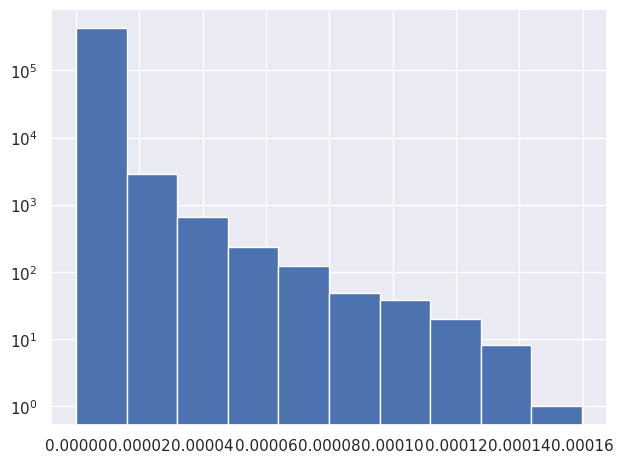

In [11]:
plt.hist(score.values());
plt.yscale("log")

In [13]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=5)
embedding = reducer.fit_transform(normalized_df)